## Tasks

- [x] Time current version (use %timeit)
- [x] Modify bisection search method to sequential, ordered calls, and compare time performance

In [1]:
import numpy as np

def spline(x, y, n, yp1, ypn, y2):
    """
    From Numerical Recipes, 2nd Ed., Sec. 3.3, p. 115
    
    Given arrays x[0..(n-1)] and y[0..(n-1)] containing an ordered,
    tabulated function, i.e., y_i = f(x_i), with x_0 < x_1 < ...
    < x_(n-1), and given values yp1 and ypn for the first derivative
    of the interpolating function at points 0 and (n-1), respectively,
    this routine returns an array y2[0..(n-1)] that contains the
    second derivatives of the interpolating function at the
    tabulated points x_i. If yp1 and/or ypn are equal to
    1e30 or larger, the routine is signaled to set the
    corresponding boundary condition for a natural spline, with
    zero second derivative on that boundary.
    """    
    u = np.zeros(n)
    if yp1 > .99e30: # "natural" lower boundary condition
        y2[0] = u[0] = 0.
    else:            # specified first derivative
        y2[0] = -0.5
        u[0] = (3./(x[1]-x[0]))*((y[1]-y[0])/(x[1]-x[0])-yp1)
    
    # decomposition loop of the tridiagonal algorithm.
    # y2 and u are used for temporary storage of the
    # decomposed factors
    for i in range(1, n-1):
        sig = (x[i] - x[i-1])/(x[i+1] - x[i-1])
        p = sig*y2[i-1] + 2.
        y2[i] = (sig - 1.)/p
        u[i] = (y[i+1]-y[i])/(x[i+1]-x[i])-(y[i]-y[i-1])/(x[i]-x[i-1])
        u[i] = (6.*u[i]/(x[i+1]-x[i-1])-sig*u[i-1])/p
        
    if (ypn > .99e30): # "natural" upper boundary condition
        qn = un = 0.
    else:              # specified first derivative
        qn = 0.5
        un = (3./(x[n-1]-x[n-2]))*(ypn-(y[n-1]-y[n-2])/(x[n-1]-x[n-2]))
    
    y2[n-1] = (un - qn*u[n-2])/(qn*y2[n-2]+1.)
    
    k = n-2 # backsubstitution loop of the tridiagonal algorithm
    while k >= 0:
        y2[k] = y2[k]*y2[k+1]+u[k]
        k -= 1

> It is important to understand that the program `spline` is called only _once_ to process an entire tabulated function in arrays `x`$_i$ and `y`$_i$. Once this has been done, values of the interpolated function for any value of _x_ are obtained by calls (as many as desired) to a separate routine `spline` (for "*spl*ine *int*erpolation")

_Numerical Recipes_, 2nd Ed., p. 116

In [2]:
def splintr(xa, ya, y2a, n, x):
    """
    From Numerical Recipes, 2nd Ed., Sec. 3.3, p. 116
    
    Given the arrays xa[1..n] and ya[1..n], which tabulate a
    function (with the xa_i's in order), and given the array
    y2a[1..n], which is the output from `spline()`, and given a
    value of x, this routine returns a cubic-spline interpolated
    value y.
    
    Uses binary search of table--optimized for sequential calls
    for random values of x.
    """
    klo = 0
    khi = n-1
    
    # We find the right place in the table by means of bisection.
    # This is optimal if sequential calls to this routine are at
    # random values of x. If sequential calls are in order, and
    # closely spaced, one would do better to store previous values
    # of klo and khi and test if they remain appropriate on the
    # next call
    while (khi - klo) > 1:
        k = (khi + klo) >> 1
        if xa[k] > x:
            khi = k
        else:
            klo = k
    # klo and khi now bracket the input value of x.
    
    h = xa[khi] - xa[klo]
    if h == 0:
        print("ERROR: Bad xa input to routine splint")
    a = (xa[khi] - x) / h
    b = (x - xa[klo]) / h
    return a*ya[klo]+b*ya[khi]+((a*a*a-a)*y2a[klo]+(b*b*b-b)*y2a[khi])*(h*h)/6.

In [3]:
def randspline(xs, y_int):
    """
    Sequential call of `splintr()` to be used with %timeit
    """
    for i in range(xs.size):
        y_int[i] = splintr(xa, ya, y2a, n, x[i])

In [4]:
import matplotlib.pyplot as plt

def splineplot(fignum, bctype):
    """
    Matplotlib script to plot dataset and interpolation.
    """
    plt.figure(figsize=(5,5))
    plt.title(r'Figure %d. $Dataset \hspace{0.5}\#%d$'%(fignum, fignum),
              fontsize='xx-large', fontweight='bold')
    plt.xlabel(r'$x$', fontsize='large')
    plt.ylabel(r'$y$', fontsize='large')
    plt.axvline(color='k')
    plt.axhline(color='k')
    plt.plot(xa, ya, 'o', label='$y_i(x_i)$')
    plt.plot(x, y_int, label='Cubic spline\n(%s)'%(bctype))
    plt.legend(loc='best', fontsize='x-large')
    plt.grid()
    plt.show()

483 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


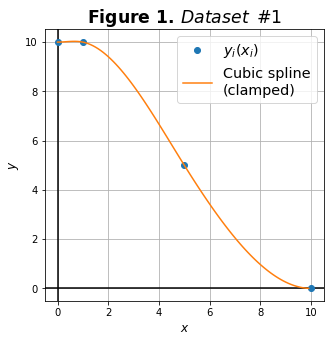

In [5]:
xa = [0, 1, 5, 10]
ya = [10, 10, 5, 0]
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 0, 0, y2a)
x = np.arange(0, 10, .1)
y_int = np.zeros(x.size)

%timeit randspline(x, y_int)
splineplot(1, "clamped")

468 µs ± 63.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


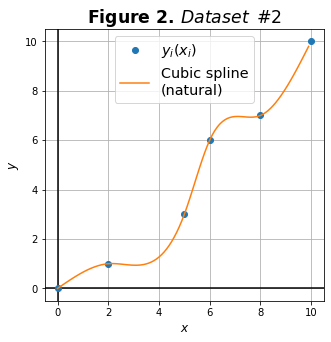

In [6]:
xa = [0, 2, 5, 6, 8, 10]
ya = [0, 1, 3, 6, 7, 10]
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 1e30, 1e30, y2a)
x = np.arange(0, 10, .1)
y_int = np.zeros(x.size)

%timeit randspline(x, y_int)
splineplot(2, "natural")

17.7 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


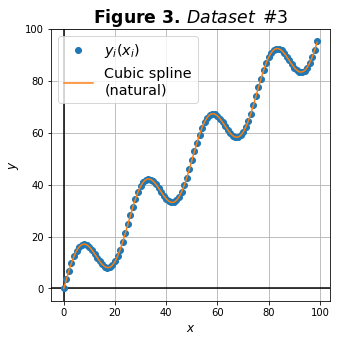

In [7]:
xa = np.arange(0, 100, 1)
ya = 10*np.sin(xa/4) + xa
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 1e30, 1e30, y2a)
x = np.arange(0, 99, .1)
y_int = np.zeros(x.size)

%timeit randspline(x, y_int)
splineplot(3, "natural")

In [8]:
def splints(xa, ya, y2a, n, x, klo):
    """
    From Numerical Recipes, 2nd Ed., Sec. 3.3, p. 116
    
    Given the arrays xa[1..n] and ya[1..n], which tabulate a
    function (with the xa_i's in order), and given the array
    y2a[1..n], which is the output from `spline()`, and given a
    value of x, this routine returns a cubic-spline interpolated
    value y.
    
    Updates previous value of klo as needed if no longer valid for 
    current call. 
    """   
    # If sequential calls are in order, and
    # closely spaced, one would do better to store previous values
    # of klo and khi and test if they remain appropriate on the
    # next call
    while xa[klo+1] < x:
        klo += 1
    
    h = xa[klo+1] - xa[klo]
    if h == 0:
        print("ERROR: Bad xa input to routine splint")
    a = (xa[klo+1] - x) / h
    b = (x - xa[klo]) / h
    return a*ya[klo]+b*ya[klo+1]+((a*a*a-a)*y2a[klo]+(b*b*b-b)*y2a[klo+1])*(h*h)/6., klo

In [9]:
def seqspline(xs, y_int, klo):
    """
    Sequential call of `splints()` to be used with %timeit
    """
    for i in range(xs.size):
        y_int[i], klo = splints(xa, ya, y2a, n, x[i], klo)

374 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


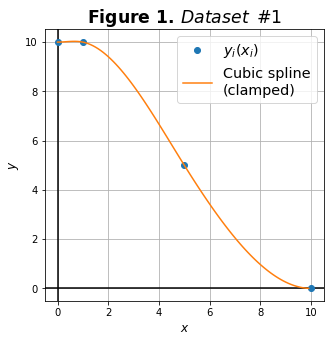

In [10]:
xa = [0, 1, 5, 10]
ya = [10, 10, 5, 0]
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 0, 0, y2a)
x = np.arange(0, 10, .1)
y_int = np.zeros(x.size)
klo = 0

%timeit seqspline(x, y_int, klo)
splineplot(1, "clamped")

409 µs ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


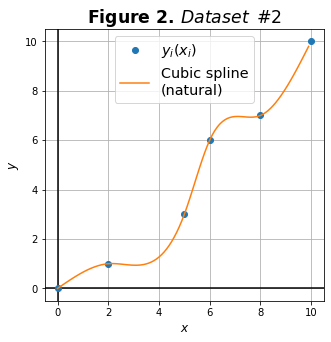

In [11]:
xa = [0, 2, 5, 6, 8, 10]
ya = [0, 1, 3, 6, 7, 10]
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 1e30, 1e30, y2a)
x = np.arange(0, 10, .1)
y_int = np.zeros(x.size)
klo = 0

%timeit seqspline(x, y_int, klo)
splineplot(2, "natural")

7.67 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


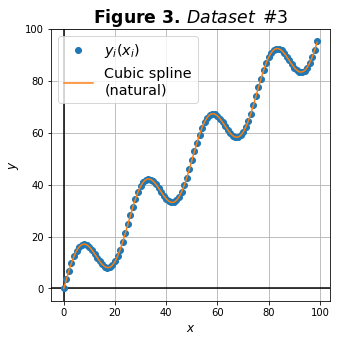

In [12]:
xa = np.arange(0, 100, 1)
ya = 10*np.sin(xa/4) + xa
n = len(xa)
y2a = np.zeros(n)
spline(xa, ya, n, 1e30, 1e30, y2a)
x = np.arange(0, 99, .1)
y_int = np.zeros(x.size)
klo = 0

%timeit seqspline(x, y_int, klo)
splineplot(3, "natural")